# PUB - cell state probe

In [1]:
from pathlib import Path
import numpy as np 
import xarray as xr 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
import pandas as pd

import sys
sys.path.append("/home/tommy/neuralhydrology")
from scripts.read_nh_results import (
    get_test_filepath,
    get_all_station_ds,
    calculate_all_error_metrics,
    get_ensemble_path,
)

from scripts.read_model import (get_model, _load_weights)
from scripts.read_nh_results import (read_multi_experiment_results, calculate_member_errors)
from neuralhydrology.utils.config import Config

%load_ext autoreload
%autoreload 2

data_dir = Path("/datadrive/data")

# Load the data

In [2]:
# run_dir = Path("/datadrive/data/runs/azure_nh_runoff_30EPOCH_0306_173310")
# run_dir = Path("/datadrive/data/runs/azure_nh_runoff_30EPOCH_0306_200242")
run_dir = Path("/home/tommy/neuralhydrology/runs/lstm_PUB_azure_3006_101251")

# load config
cfg = Config(run_dir / "config.yml")
cfg.run_dir = run_dir

In [3]:
res_fp = get_test_filepath(run_dir, epoch=30)
preds = get_all_station_ds(res_fp)
preds["station_id"] = preds["station_id"].astype(int)

100%|██████████| 134/134 [00:00<00:00, 1990.12it/s]


# Load model

In [4]:
# load trained model
model = get_model(cfg).to(cfg.device)
_load_weights(model, cfg)
model

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


Using the model weights from /home/tommy/neuralhydrology/runs/lstm_PUB_azure_3006_101251/model_epoch030.pt


CudaLSTM(
  (embedding_net): InputLayer(
    (statics_embedding): Identity()
    (dynamics_embedding): Identity()
  )
  (lstm): LSTM(25, 64)
  (dropout): Dropout(p=0.4, inplace=False)
  (head): Regression(
    (net): Sequential(
      (0): Linear(in_features=64, out_features=1, bias=True)
    )
  )
)

# Get training/test dataset

In [5]:
ds = xr.open_dataset("/home/tommy/spatio_temporal/data/ALL_dynamic_ds.nc")

def read_basin_list(txt_path: Path) -> pd.DataFrame:
    return pd.read_csv(txt_path, header=None).rename({0: "station_id"}, axis=1)


train_sids = read_basin_list(cfg.train_basin_file)
test_sids = read_basin_list(cfg.test_basin_file)
train_ds = ds.sel(time=slice(cfg.train_start_date, cfg.train_end_date), station_id=np.isin(ds.station_id, train_sids.station_id))
test_ds = ds.sel(time=slice(cfg.test_start_date, cfg.test_end_date), station_id=np.isin(ds.station_id, test_sids.station_id))

# Probe the out-of-sample basins

In [6]:
from scripts.cell_state.extract_cell_state import get_cell_states
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

subset = "train"
out_dir = run_dir / f"cell_states"
if not out_dir.exists():
    out_dir.mkdir(parents=True, exist_ok=True)

if not (out_dir / f"{subset}_cell_states.nc").exists():
    cn = get_cell_states(cfg, run_dir, subset=subset)
    cn.to_netcdf(out_dir / f"{subset}_cell_states.nc")
else:
    cn = xr.open_dataset(out_dir / f"{subset}_cell_states.nc")
    
train_cn = xr.open_dataset(out_dir / f"train_cell_states.nc")
test_cn = xr.open_dataset(out_dir / f"test_cell_states.nc")

# Normalisation strategy - global or local?

In [16]:
PER_BASIN = False  # True = PER BASIN

In [23]:
from scripts.cell_state.normalize import normalize_cstate
from scripts.cell_state.cell_state_dataset import dataset_dimensions_to_variable

fname_base = "per_basin" if PER_BASIN else "global"
if (out_dir / f"{fname_base}_train_cs.nc").exists():
    train_cs = xr.open_dataset(out_dir / f"{fname_base}_train_cs.nc")
else:
    train_norm_cs_data = normalize_cstate(train_cn, variable_str="c_n", per_basin=PER_BASIN, time_dim="date")
    train_cs = dataset_dimensions_to_variable(
        ds=train_norm_cs_data.to_dataset() if isinstance(train_norm_cs_data, xr.DataArray) else train_norm_cs_data,
        variable="c_n",
        dimension_to_convert_to_variable_dim="dimension",
        time_dim="date"
    )
    train_cs.to_netcdf(out_dir / f"{fname_base}_train_cs.nc")

In [25]:
if (out_dir / f"{fname_base}_test_cs.nc").exists():
    test_cs = xr.open_dataset(out_dir / f"{fname_base}_test_cs.nc")
else:
    test_norm_cs_data = normalize_cstate(test_cn, variable_str="c_n", per_basin=PER_BASIN, time_dim="date")
    test_cs = dataset_dimensions_to_variable(
        ds=test_norm_cs_data.to_dataset() if isinstance(test_norm_cs_data, xr.DataArray) else test_norm_cs_data,
        variable="c_n",
        dimension_to_convert_to_variable_dim="dimension",
        time_dim="date"
    )
    test_cs.to_netcdf(out_dir / f"{fname_base}_test_cs.nc")

In [26]:
train_cs["station_id"] = train_cs["station_id"].astype(int)
test_cs["station_id"] = test_cs["station_id"].astype(int)

train_cs = train_cs.rename({"date": "time"})
test_cs = test_cs.rename({"date": "time"})

# Target Data

In [27]:
TARGET = "ESA"

In [28]:
from scripts.cell_state.normalize import normalize_2d_dataset



if TARGET == "ERA5":
    filepath = data_dir / "camels_basin_ERA5Land_sm.nc"
    era5_ds = xr.open_dataset(filepath)

    if not isinstance(era5_ds, xr.Dataset):
        era5_ds = era5_ds.to_dataset()

    for var in era5_ds.data_vars:
        era5_ds[var] = normalize_2d_dataset(era5_ds, variable_str=var, per_basin=PER_BASIN)

    era5_ds["station_id"] = era5_ds["station_id"].astype(int)

    # NOT for snow depth ..?
    era5_ds = era5_ds.drop("sd")
    target_ds = era5_ds

elif TARGET == "ESA":
    filepath = data_dir / "SOIL_MOISTURE/interp_full_timeseries_esa_cci_sm.nc"
    esa_ds = xr.open_dataset(filepath).drop("spatial_ref")
    if not isinstance(esa_ds, xr.Dataset):
        esa_ds = esa_ds.to_dataset()

    for var in esa_ds.data_vars:
        esa_ds[var] = normalize_2d_dataset(esa_ds, variable_str=var, per_basin=PER_BASIN)

    esa_ds["station_id"] = esa_ds["station_id"].astype(int)
    target_ds = esa_ds
else:
    assert False
    

# Train - Test DataLoaders

In [29]:
train_target_ds = target_ds.sel(station_id=train_cs.station_id, time=train_cs.time)
test_target_ds = target_ds.sel(station_id=np.isin(target_ds.station_id, test_cs.station_id), time=test_cs.time)

input_variables = list(train_cs.data_vars)
seq_length = 1
basin_dim = "station_id"
time_dim = "time"

In [30]:
# train_target_ds
# test_target_ds
# train_cs
# test_cs

test_cs

<xarray.Dataset>
Dimensions:     (station_id: 134, time: 4018)
Coordinates:
  * time        (time) datetime64[ns] 1998-01-01 1998-01-02 ... 2008-12-31
  * station_id  (station_id) int64 102001 107001 12001 ... 9004 94001 96001
Data variables: (12/64)
    dim0        (time, station_id) float32 0.5607 0.01805 ... -0.8533 -3.731
    dim1        (time, station_id) float32 -0.1486 -0.2 -1.009 ... -4.101 0.1493
    dim2        (time, station_id) float32 0.7155 0.1803 ... -0.4394 0.141
    dim3        (time, station_id) float32 -0.1196 -0.1841 ... -0.1275 -0.2295
    dim4        (time, station_id) float32 -0.3395 -0.3393 ... -0.3393 -0.3393
    dim5        (time, station_id) float32 -0.124 -0.08236 ... 12.07 0.2695
    ...          ...
    dim58       (time, station_id) float32 -0.3722 4.123 ... 0.1032 -0.3552
    dim59       (time, station_id) float32 0.2473 -0.4284 ... -0.4774 -3.091
    dim60       (time, station_id) float32 -0.1568 -0.02336 ... 0.01142 -0.16
    dim61       (time, station_id) float32 -0.08532 -0.5542 ... 0.08934 -1.136
    dim62       (time, station_id) float32 0.6381 0.6394 0.6293 ... 0.6175 0.639
    dim63       (time, station_id) float32 -1.416 0.7499 ... 0.7163 -0.6856

In [37]:
from collections import defaultdict
from scripts.cell_state.timeseries_dataset import TimeSeriesDataset, get_time_basin_aligned_dictionary

if "all_train_test" not in globals():
    all_train_test = defaultdict(dict)
    for target_var in [v for v in target_ds.data_vars]:
        print(f"** STARTING {target_var} **")
        train_dataset = TimeSeriesDataset(
            input_data=train_cs,
            target_data=train_target_ds,
            target_variable=target_var,
            input_variables=input_variables,
            seq_length=seq_length,
            basin_dim=basin_dim,
            time_dim=time_dim,
            desc="Creating Train Samples",
        )

        train = get_time_basin_aligned_dictionary(train_dataset)

        test_dataset = TimeSeriesDataset(
            input_data=test_cs,
            target_data=test_target_ds,
            target_variable=target_var,
            input_variables=input_variables,
            seq_length=seq_length,
            basin_dim=basin_dim,
            time_dim=time_dim,
            desc="Creating Test Samples",
        )

        test = get_time_basin_aligned_dictionary(test_dataset)

        all_train_test[target_var]["train"] = train
        all_train_test[target_var]["test"] = test
else:
    print("Already loaded all_train_test data")

** STARTING sm **


Extracting Data: 100%|██████████| 7627/7627 [00:57<00:00, 131.74it/s]


Merging and reshaping arrays


Extracting Data: 100%|██████████| 2087/2087 [00:15<00:00, 134.30it/s]


Merging and reshaping arrays
** STARTING 7_day_smooth_sm **


Extracting Data: 100%|██████████| 7627/7627 [00:59<00:00, 128.76it/s]


Merging and reshaping arrays


Extracting Data: 100%|██████████| 2087/2087 [00:15<00:00, 136.74it/s]


Merging and reshaping arrays


# Train Probe

In [38]:
from scripts.cell_state.sklearn_models import (
    init_linear_model,
    evaluate,
    create_analysis_dataset,
    fit_and_predict,
)
from scripts.cell_state.analysis import (save_probe_components, load_probe_components)

In [39]:
# initalise the model 
all_models_preds = defaultdict(dict)
target_vars = [v for v in target_ds.data_vars]

for target_var in [v for v in target_ds.data_vars]:
    print(f"** {target_var} **")
    model, preds, errors = fit_and_predict(all_train_test[target_var]["train"], all_train_test[target_var]["test"], random_seed=100)
    all_models_preds[target_var]["model"] = model
    all_models_preds[target_var]["preds"] = preds
    all_models_preds[target_var]["errors"] = errors
    
# save_probe_components(run_dir=run_dir, all_models_preds=all_models_preds)

** sm **
-- Epoch 1
Norm: 0.64, NNZs: 29, Bias: -0.281644, T: 1757233, Avg. loss: 0.053909
Total training time: 1.44 seconds.
-- Epoch 2
Norm: 0.64, NNZs: 29, Bias: -0.281405, T: 3514466, Avg. loss: 0.053856
Total training time: 3.03 seconds.
-- Epoch 3
Norm: 0.64, NNZs: 29, Bias: -0.281263, T: 5271699, Avg. loss: 0.053851
Total training time: 4.62 seconds.
-- Epoch 4
Norm: 0.64, NNZs: 29, Bias: -0.281171, T: 7028932, Avg. loss: 0.053846
Total training time: 6.19 seconds.
Convergence after 4 epochs took 6.33 seconds


Calculating Errors: 100%|██████████| 133/133 [00:01<00:00, 81.45it/s, 102001]


** 7_day_smooth_sm **
-- Epoch 1
Norm: 0.66, NNZs: 30, Bias: -0.294841, T: 1757228, Avg. loss: 0.053000
Total training time: 1.42 seconds.
-- Epoch 2
Norm: 0.66, NNZs: 30, Bias: -0.287623, T: 3514456, Avg. loss: 0.052936
Total training time: 2.99 seconds.
-- Epoch 3
Norm: 0.66, NNZs: 29, Bias: -0.293345, T: 5271684, Avg. loss: 0.052935
Total training time: 4.56 seconds.
-- Epoch 4
Norm: 0.66, NNZs: 30, Bias: -0.293119, T: 7028912, Avg. loss: 0.052935
Total training time: 6.13 seconds.
Convergence after 4 epochs took 6.28 seconds


Calculating Errors: 100%|██████████| 133/133 [00:01<00:00, 84.75it/s, 102001]


# Evaluate Probe

In [40]:
preds = all_models_preds[target_var]["preds"]

errors = calculate_all_error_metrics(
    preds,
    basin_coord="station_id",
    time_coord="time",
    obs_var="obs",
    sim_var="sim",
    metrics=["NSE"],
)

Calculating Errors: 100%|██████████| 133/133 [00:01<00:00, 115.45it/s, 102001]


# Plot Results

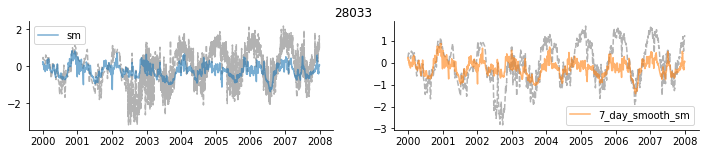

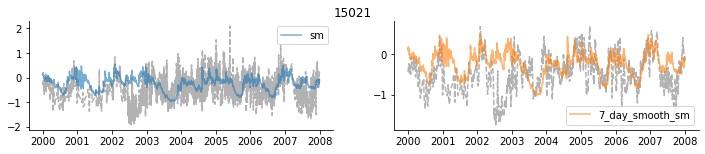

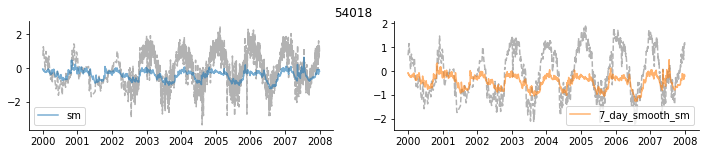

In [41]:
p = all_models_preds[target_vars[0]]["preds"]
time = slice("2000", "2007")

N = 3
pixels = np.random.choice(p.station_id.values, N, replace=False)
# pixels = [27030, 38012, 39017]

for px in pixels:
    if TARGET == "ESA":
        f, axs = plt.subplots(1, 2, figsize=(12, 4 if TARGET != "ESA" else 2), sharex=True)
    else:
        f, axs = plt.subplots(2, 2, figsize=(12, 4 if TARGET != "ESA" else 2), sharex=True)
    f.suptitle(px)
    for ix, target_var in enumerate(target_vars):
        ax = axs[np.unravel_index(ix, (2, 2)) if TARGET != "ESA" else ix]
        preds = all_models_preds[target_var]["preds"]
        data = preds.sel(station_id=px, time=time)

        ax.plot(data.time, data.obs, color="k", ls="--", alpha=0.3)
        ax.plot(data.time, data.sim, color=f"C{ix}", ls="-", alpha=0.6, label=f"{target_var}")
        ax.legend()
        sns.despine()

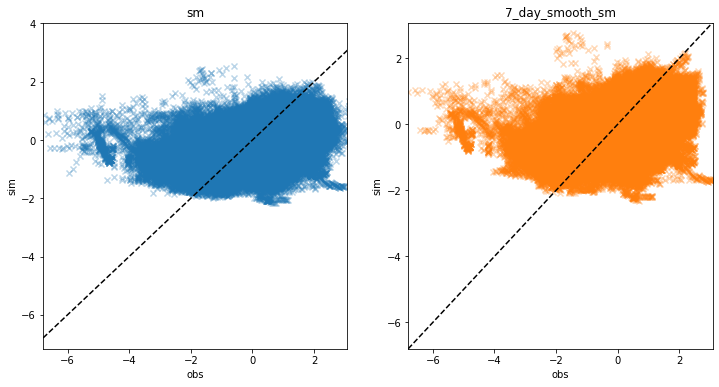

In [56]:
from scripts.plots import scatter_plot

if TARGET == "ESA":
    f, axs = plt.subplots(1, 2, figsize=(6 * 2, 6), sharex=True)
else:
    f, axs = plt.subplots(2, 2, figsize=(6 * 2, 6 * 2), sharex=True)

for ix, target_var in enumerate(target_vars):
    ax = axs[np.unravel_index(ix, (2, 2)) if TARGET != "ESA" else ix]
    preds = all_models_preds[target_var]["preds"]

    x, y = preds["obs"].values.flatten(), preds["sim"].values.flatten()
    scatter_plot(obs=x, sim=y, ax=ax, scatter_kwargs={"marker": "x", "color": f"C{ix}", "alpha": 0.3})
    ax.set_title(target_var)

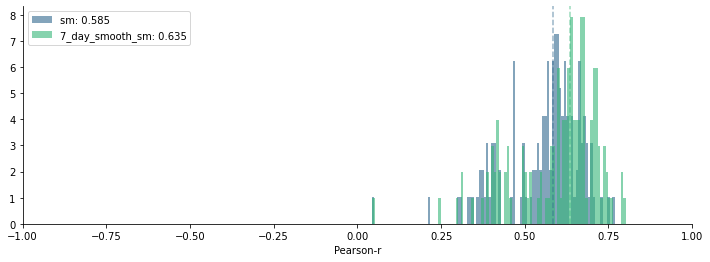

In [57]:
metric = "Pearson-r"
f, ax = plt.subplots(figsize=(12, 4))

colors = sns.color_palette("viridis", n_colors=len(target_vars))
for ix, target_var in enumerate(target_vars):
    errors = all_models_preds[target_var]["errors"]
    nse = errors[metric]

    ax.hist(nse.where(nse > -1, -1), bins=100, density=True, label=f"{target_var}: {nse.median().values:.3f}", alpha=0.6, color=colors[ix]);
    ax.axvline(nse.median(), color=colors[ix], ls="--", alpha=0.5)
    

ax.set_xlabel(metric)
ax.set_xlim(-1, 1)
ax.legend()
sns.despine()

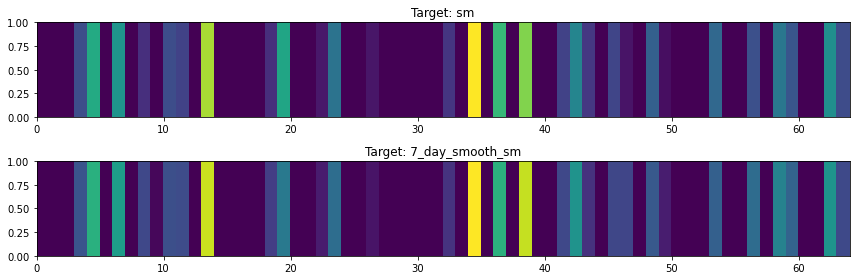

In [43]:
from scripts.cell_state.analysis import get_model_weights, plot_weights

n_plots = len(target_vars)
f, axs = plt.subplots(n_plots, 1, figsize=(12, 2*n_plots))

for ix, target_var in enumerate(target_vars):
    model = all_models_preds[target_var]["model"]
    ax = axs[ix]
    w, b = get_model_weights(model)
    plot_weights(np.abs(w), kwargs={"vmin": 0.0, "vmax": 0.15}, ax=ax, cbar=False)
    ax.set_title(f"Target: {target_var}")
plt.tight_layout()

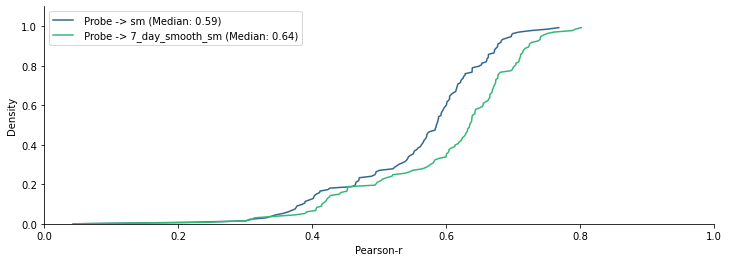

In [58]:
from typing import Any, Dict
import seaborn as sns
import matplotlib.pyplot as plt


def empirical_cdf(errors: np.ndarray, kwargs: Dict[str, Any] = {}):
    x = np.sort(errors)
    y = np.arange(len(x))/float(len(x))
    plt.plot(x, y, **kwargs)

    
f, ax = plt.subplots(figsize=(12, 4))
colors = sns.color_palette("viridis", n_colors=len(target_vars))
for ix, target_var in enumerate(target_vars):
    errors = all_models_preds[target_var]["errors"]
    nse = errors[metric]
    med_nse = f"{(np.median(nse)):.2f}"
    empirical_cdf(nse, kwargs={"label": f" Probe -> {target_var} (Median: {med_nse})", "color": colors[ix]})

ax.set_xlim(0, 1)
ax.set_ylim(0, 1.1)
ax.set_xlabel(metric)
ax.set_ylabel("Density")
plt.legend()
sns.despine()

# What about individual cell states?

In [45]:
def get_ws_bs_for_target_var(all_models_preds, target_var: str):
    model = all_models_preds[target_var]["model"]
    w, b = get_model_weights(model)
    return w, b

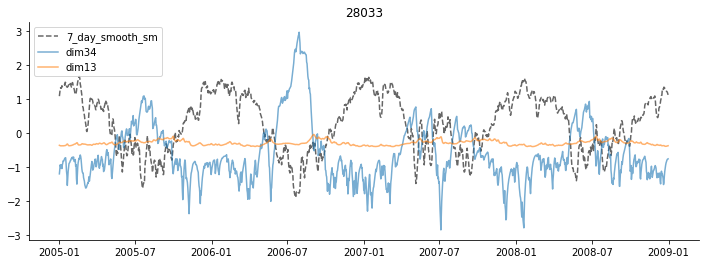

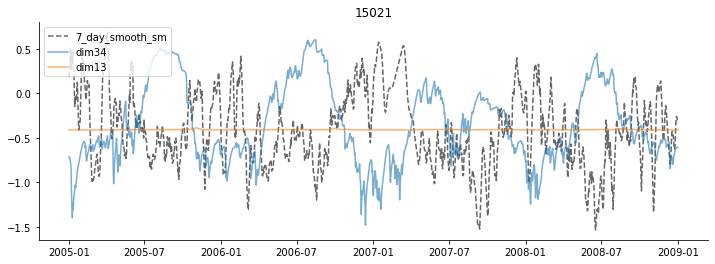

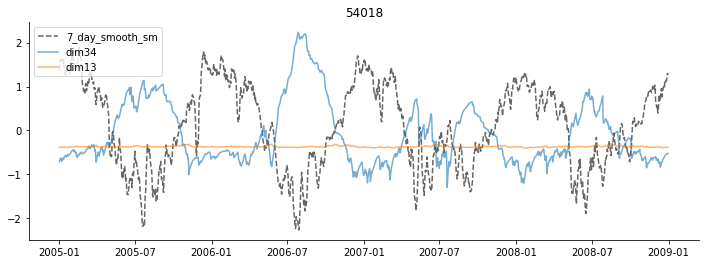

In [49]:
target_var = "7_day_smooth_sm" if TARGET == "ESA" else "swvl1"
# N_dims = 3
time = slice("2005", "2008")
Npxs = 2
N_dims = 2

w, b = get_ws_bs_for_target_var(all_models_preds, target_var)
max_idx = np.argmax(np.abs(w))
largest_n = np.abs(w).argsort()[-N_dims:][::-1]
features = [f"dim{idx}" for idx in largest_n]

pxs = np.random.choice(test_cs.station_id.values, Npxs)
pxs = [28033, 15021, 54018]

for px in pxs:
    f, ax = plt.subplots(figsize=(12, 4))
    data = test_cs.sel(station_id=px, time=time).to_dataframe()
    target = target_ds.sel(station_id=px, time=time).to_dataframe()

    ax.plot(target.index, target[target_var], label=target_var, color="k", ls="--", alpha=0.6)
    ax.legend(loc="upper right")
    ax.set_title(px)

    # ax2 = ax.twinx()
    for ix, feature in enumerate(features):  # features  ["dim20"]  ["dim58"]
        ax.plot(data.index, data[feature], label=f"{feature}", color=f"C{ix}", alpha=0.6)
        ax.legend(loc="upper left")

    sns.despine()

# Mutual information vs. correlation vs. SGD Regressor

In [47]:
assert False

AssertionError: 

In [ ]:
df = pd.DataFrame({"regression": w}).reset_index().rename({"index": "dimension"}, axis=1)
df.head()

#### correlation

In [ ]:
var_ = "7_day_smooth_sm" if TARGET == "ESA" else "swvl1"

x = all_train_test[var_]["train"]["X"]
y = all_train_test[var_]["train"]["y"]

In [ ]:
from numpy import cov

all_cov = cov(x, y, rowvar=False, bias=False)
all_cov = all_cov[:, -1][:-1]

df["correlation"] = all_cov
df.head()

#### mutual information

In [ ]:
from sklearn.feature_selection import mutual_info_regression
from tqdm import tqdm 


all_mi = []
for dim_ix in tqdm(range(x.shape[-1])):
    mi_score = mutual_info_regression(x[:, dim_ix].reshape(-1, 1), y.ravel())[0]
    all_mi.append(mi_score)

df["mutual_information"] = all_mi

#### Plot

# Non-Linear Model

In [53]:
from scripts.cell_state.sklearn_models import fit_and_predict

if "nonlinear_dict" not in globals().keys():
    # initalise the model 
    nonlinear_dict = defaultdict(dict)
    target_vars = [v for v in target_ds.data_vars]

    for target_var in [v for v in target_ds.data_vars]:
        print(f"** {target_var} **")
        model, preds, errors = fit_and_predict(
            all_train_test[target_var]["train"], 
            all_train_test[target_var]["test"], 
            random_seed=100, 
            linear=False, 
            hidden_sizes=[10,10]
        )
        nonlinear_dict[target_var]["model"] = model
        nonlinear_dict[target_var]["preds"] = preds
        nonlinear_dict[target_var]["errors"] = errors

** sm **
Iteration 1, loss = 0.26032023
Validation score: 0.514110
Iteration 2, loss = 0.23379566
Validation score: 0.532258
Iteration 3, loss = 0.22943686
Validation score: 0.536556
Iteration 4, loss = 0.22757891
Validation score: 0.535330
Iteration 5, loss = 0.22689948
Validation score: 0.538039
Iteration 6, loss = 0.22612737
Validation score: 0.542602
Iteration 7, loss = 0.22506945
Validation score: 0.546147
Iteration 8, loss = 0.22427205
Validation score: 0.545009
Iteration 9, loss = 0.22325304
Validation score: 0.549773
Iteration 10, loss = 0.22280886
Validation score: 0.552474
Iteration 11, loss = 0.22263700
Validation score: 0.550449
Iteration 12, loss = 0.22235387
Validation score: 0.551965
Iteration 13, loss = 0.22223528
Validation score: 0.554767
Iteration 14, loss = 0.22205980
Validation score: 0.555132
Iteration 15, loss = 0.22199815
Validation score: 0.554009
Iteration 16, loss = 0.22187619
Validation score: 0.549278
Iteration 17, loss = 0.22174069
Validation score: 0.5530

Calculating Errors: 100%|██████████| 133/133 [00:01<00:00, 82.44it/s, 102001]


** 7_day_smooth_sm **
Iteration 1, loss = 0.24336032
Validation score: 0.549911
Iteration 2, loss = 0.21684775
Validation score: 0.567522
Iteration 3, loss = 0.21149623
Validation score: 0.575747
Iteration 4, loss = 0.20889200
Validation score: 0.582396
Iteration 5, loss = 0.20724992
Validation score: 0.580111
Iteration 6, loss = 0.20612461
Validation score: 0.591242
Iteration 7, loss = 0.20512898
Validation score: 0.586410
Iteration 8, loss = 0.20423447
Validation score: 0.592268
Iteration 9, loss = 0.20370357
Validation score: 0.591968
Iteration 10, loss = 0.20348605
Validation score: 0.594069
Iteration 11, loss = 0.20323253
Validation score: 0.594743
Iteration 12, loss = 0.20299648
Validation score: 0.593748
Iteration 13, loss = 0.20284609
Validation score: 0.592661
Iteration 14, loss = 0.20268714
Validation score: 0.592946
Iteration 15, loss = 0.20258585
Validation score: 0.596795
Iteration 16, loss = 0.20238813
Validation score: 0.596581
Iteration 17, loss = 0.20202495
Validation 

Calculating Errors: 100%|██████████| 133/133 [00:01<00:00, 85.61it/s, 102001]


In [ ]:
p = nonlinear_dict["storGroundwater"]["preds"]
time = "2007"

N = 2
pixels = np.random.choice(p.station_id.values, N, replace=False)

for px in pixels:
    f, axs = plt.subplots(2, 2, figsize=(12, 2*3), sharex=True)
    for ix, target_var in enumerate(target_vars):
        ax = axs[np.unravel_index(ix, (2, 2))]
        preds = nonlinear_dict[target_var]["preds"]
        data = preds.sel(station_id=px, time=time)

    #     f, ax = plt.subplots(figsize=(12, 4))
        ax.plot(data.time, data.obs, color="k", ls="--", alpha=0.3, label="Obs")
        ax.plot(data.time, data.sim, color=f"C{ix}", ls="-", alpha=0.6, label=f"{target_var}")
        ax.legend()
        sns.despine()

In [ ]:
f, ax = plt.subplots(figsize=(12, 4))

colors = sns.color_palette("viridis", n_colors=len(target_vars))
for ix, target_var in enumerate(target_vars):
    errors = nonlinear_dict[target_var]["errors"]
    nse = errors["NSE"]

    ax.hist(nse.where(nse > -1, -1), bins=100, density=True, label=f"{target_var}: {nse.median().values:.3f}", alpha=0.6, color=colors[ix]);
    ax.axvline(nse.median(), color=colors[ix], ls="--", alpha=0.5)
    

ax.set_xlim(-1, 1)
ax.legend()
sns.despine()